In [1]:
import numpy as np
from dataclasses import dataclass

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import convolve2d

In [25]:
grid = np.zeros((10,10))
grid[1,1]= 1
grid[1,2] = 1
grid[2,2] = 1
kernel = np.array([[1.,1.,1.],[1.,0.,1.],[1.,1.,1.]])

convolve2d(grid,kernel,mode="same",boundary="wrap")

array([[1., 2., 2., 1., 0., 0., 0., 0., 0., 0.],
       [1., 2., 2., 2., 0., 0., 0., 0., 0., 0.],
       [1., 3., 2., 2., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [8]:
@dataclass
class Cell():
    alive: bool = False

    def set(self,state):
        self.alive = state

    def get(self):
        return self.alive
    
class Lattice():
    def __init__(self,size: int):
        self.size = size
        self.grid = np.array([[Cell() for i in range(self.size)] for j in range(self.size)])

    def set_state(self, idx: list[tuple[int,int]], state: bool):
        row_idx = [row for row, _ in idx]
        col_idx = [col for _, col in idx]

        for cell in self.grid[row_idx,col_idx]:
            cell.set(state)


    def get_states(self, grid = None):
        if grid is not None:
            return np.array([[cell.get() for cell in row] for row in grid])
        else:
            return np.array([[cell.get() for cell in row] for row in self.grid])
    
    def plot(self, ax = None):
        data_ = self.get_states()
        if ax is not None:
            self.img = sns.heatmap(data_,cbar=False,linewidths=0.1,xticklabels=False,yticklabels=False,cmap='rocket_r',ax = ax)
        else:
            self.img = sns.heatmap(data_,cbar=False,linewidths=0.1,xticklabels=False,yticklabels=False,cmap='rocket_r')
        

    # def animate(self, frame):
    #     self.update()
    #     self.img.set_data(self.get_states())
    #     return [self.img]
        

    def update(self):
        # bottom
        bottom = self.get_states(np.roll(self.grid,-1,axis=0)).astype(int)
        # up
        up = self.get_states(np.roll(self.grid,1,axis=0)).astype(int)
        # right
        right = self.get_states(np.roll(self.grid,-1,axis=1)).astype(int)
        # left 
        left = self.get_states(np.roll(self.grid,1,axis=1)).astype(int)
        # upper right
        upper_right = self.get_states(np.roll(np.roll(self.grid,-1,axis=1),1,axis=0)).astype(int)
        # upper left
        upper_left = self.get_states(np.roll(np.roll(self.grid,1,axis=1),1,axis=0)).astype(int)
        # bottom right
        bottom_right = self.get_states(np.roll(np.roll(self.grid,-1,axis=1),-1,axis=0)).astype(int)
        # bottom left
        bottom_left = self.get_states(np.roll(np.roll(self.grid,1,axis=1),-1,axis=0)).astype(int)

        live_or_die = bottom + up + right + left + upper_left + upper_right + bottom_left + bottom_right # number of live nbrs

        # update according to Conway's Game of Life
        # conditions for live cells
        underpopulation = np.where( (live_or_die < 2) & (self.get_states() == True) ) # dies
        overpopulation = np.where( (live_or_die > 3) & (self.get_states() == True) ) # dies
        stable = np.where( ( (live_or_die == 2) | (live_or_die == 3) ) & (self.get_states() == True) ) # lives

        # conditions for dead cells
        reborn = np.where((live_or_die == 3) & (self.get_states() == False)) # lives

        # update
        for cell in self.grid[*underpopulation]:
            cell.set(False)

        for cell in self.grid[*overpopulation]:
            cell.set(False)

        for cell in self.grid[*stable]:
            cell.set(True)

        for cell in self.grid[*reborn]:
            cell.set(True)


        


* Any live cell with fewer than two live neighbours dies, as if by underpopulation.

* Any live cell with two or three live neighbours lives on to the next generation.

* Any live cell with more than three live neighbours dies, as if by overpopulation.

* Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction

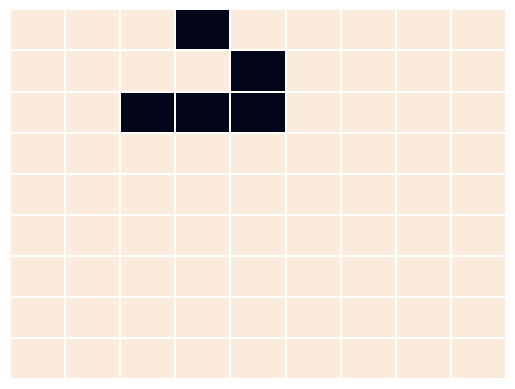

In [14]:
N = 9
lattice = Lattice(N)

blinker = [(2,1), (2,2), (2,3)]

glider = [(2,2), (2,3),(2,4),(1,4),(0,3)]


lattice.set_state(glider,True)

fig, ax = plt.subplots()

lattice.plot()


**HECS = Hexagonal Efficient Coordinate System**

parametrisation of hexagonal lattice:

* parametrisation by two arrays

* array 0 parametrises all even rows of lattice

* array 1 parametrises all odd rows of lattice 

* each hexagon uniquely identified by triple $(a,r,c) \in \{0,1\} \times \mathbb{Z} \times \mathbb{Z}$ where $a$ indexes array, $r,c$ row and coloumns

* there is a linear transformation from $T \colon \{0,1\} \times \mathbb{Z} \times \mathbb{Z} \to \mathbb{R}^2$ sending a triple $(a,r,c) \mapsto (x,y)$ to the center of the corresponding hexagon

In [18]:
size = 2

T = np.sqrt(3)*size*np.array([[0.5,0,1],[0.5*np.sqrt(3), np.sqrt(3),0]]) 

def HECS_to_Cartesian(p:np.ndarray):
   assert p.shape == (3,1), f"expected shape (3,1), got {p.shape}"

   return tuple((T @ p).flatten())

def create_hexagon(center:tuple[float,float],size):
    i,j = center 
    
    vertices = [
        (i, j + size), 
        (i - 0.5 * np.sqrt(3)*size, j + 0.5*size), 
        (i - 0.5 * np.sqrt(3)*size, j - 0.5*size), 
        (i, j - size), 
        (i + 0.5 * np.sqrt(3)*size, j - 0.5*size), 
        (i + 0.5 * np.sqrt(3)*size, j + 0.5*size), 
        ]
    return vertices

def get_neighbours(hexagon: tuple[int,int,int]):
    a,r,c = hexagon

    right = (a, r, c + 1)
    right_above = (1 - a, r - (1 - a), c + a)
    left_above = (1 - a, r - (1 - a), c - (1 - a))
    left = (a, r, c - 1)
    left_below = (1 - a, r + a, c - (1 - a))
    right_below = (1 - a, r + a, c + a)

    return (right, right_above, left_above, left, left_below, right_below)


        

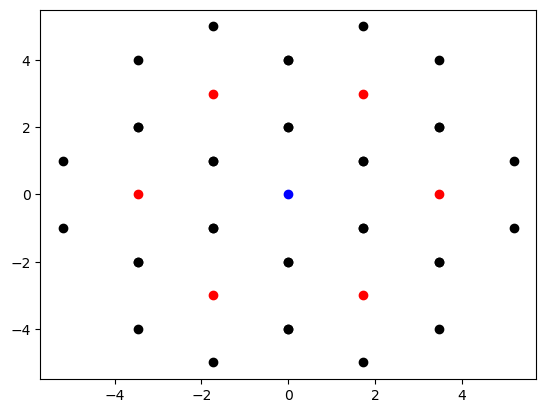

In [20]:
# TESTING get_neighbours
center0 = (0,0)
centers = []
nbrs = get_neighbours((0,0,0))

for nbr in nbrs:
    centers.append(HECS_to_Cartesian( np.array(nbr).reshape(-1,1)) )

fig, ax  = plt.subplots()

ax.scatter(*center0,color='blue')

for center in centers:
    vertices = create_hexagon(center,size)
    ax.scatter(*center,color='red')

    for x,y in vertices:
        ax.scatter(x,y,color='k')



In [36]:
foo = {1:'a'}
foo.update({2:'b',3:'c'})
foo

{1: 'a', 2: 'b', 3: 'c'}

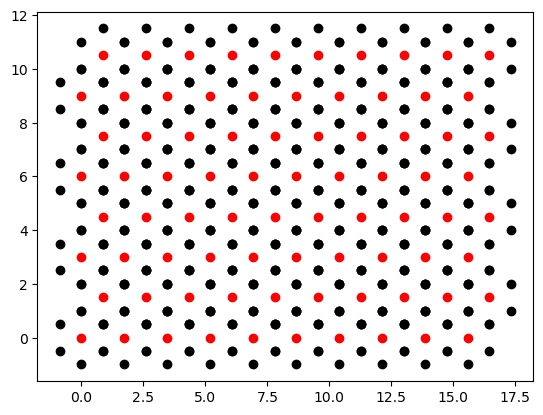

In [92]:
# TESTING HECS 
ROWS = 4
COLS = 10
even_rows = np.array([ [(0,r,c) for c  in range(COLS)] for r in range(ROWS)])
odd_rows = np.array([ [(1,r,c) for c  in range(COLS)] for r in range(ROWS)])

centers = []

for a in [even_rows,odd_rows]:
    for row in a:
        for c in row:
            centers.append(HECS_to_Cartesian(c.reshape(-1,1)))

fig, ax  = plt.subplots()

for center in centers:
    vertices = create_hexagon(center)
    ax.scatter(*center,color='red')

    for x,y in vertices:
        ax.scatter(x,y,color='k')


In [16]:
centers = [(0,0)]
vertices = []
for center in centers:
    vertices.extend(create_hexagon(center))

vertices

[(0, 1),
 (-0.8660254037844386, 0.5),
 (-0.8660254037844386, -0.5),
 (0, -1),
 (0.8660254037844386, -0.5),
 (0.8660254037844386, 0.5)]

In [109]:
@dataclass
class Cell():
    alive: bool = False

    def set(self,state):
        self.alive = state

    def get(self):
        return self.alive

class HexLattice():
    def __init__(self,rows,cols):
        self.ROWS = rows
        self.COLS = cols
        self.grid = self.create_grid()
        pass

    def create_grid(self):
        # HECS
        self.even_rows = [ [(0,r,c) for c  in range(self.COLS)] for r in range(self.ROWS)]
        self.odd_rows = [ [(1,r,c) for c  in range(self.COLS)] for r in range(self.ROWS)]
        grid = {(a,b,c):Cell() for row in self.even_rows + self.odd_rows for (a,b,c) in row}

        return grid
    
    def set_states(self, idx: list[tuple[int,int,int]], state: bool):
        for (a,b,c) in idx:
            self.grid[(a,b,c)].set(state)

    def get_alive(self):
        return [idx for idx in hex.grid.keys() if hex.grid[idx].get()]
    
    def get_states(self):
        return np.array([[[self.grid[(a,r,c)].get() for c in range(self.COLS)] for r in range(self.ROWS)]for a in range(2)])
    
    def clear(self):
        self.grid = self.create_grid()

    def get_neighbours(self,hexagon: tuple[int,int,int]):
        a,r,c = hexagon

        right = (a, r, (c + 1 ) % self.COLS)
        right_above = (1 - a, (r - (1 - a)) % self.ROWS, (c + a) % self.COLS)
        left_above = (1 - a, (r - (1 - a)) % self.ROWS, (c - (1 - a)) % self.COLS)
        left = (a, r, (c - 1) % self.COLS)
        left_below = (1 - a, (r + a) % self.ROWS, (c - (1 - a)) % self.COLS)
        right_below = (1 - a, (r + a) % self.ROWS, (c + a) % self.COLS)

        return (right, right_above, left_above, left, left_below, right_below)

    def update(self):
        current_states = self.get_states()

        for id in self.grid.keys():
            current_cell_state = self.grid[id]
            nbr_state = 0
            nbrs = self.get_neighbours(id)
            for nbr in nbrs:
                nbr_state += current_states[nbr]

            # live cells
            if current_cell_state.get() and nbr_state == 3: # live
                continue
            if current_cell_state.get() and nbr_state < 3: # die, underpopulation
                current_cell_state.set(False)
            if current_cell_state.get() and nbr_state > 3: # die, overpopulation
                current_cell_state.set(False)

            # dead cells
            if not current_cell_state.get() and nbr_state == 3: # live
                current_cell_state.set(True)

In [116]:
hex = HexLattice(2,3)
live = [(1,0,1)] + [(a,b,c) for (a,b,c) in hex.get_neighbours((1,0,1))]
hex.set_states(live,True)
hex.grid


{(0, 0, 0): Cell(alive=True),
 (0, 0, 1): Cell(alive=True),
 (0, 0, 2): Cell(alive=True),
 (0, 1, 0): Cell(alive=False),
 (0, 1, 1): Cell(alive=False),
 (0, 1, 2): Cell(alive=False),
 (1, 0, 0): Cell(alive=True),
 (1, 0, 1): Cell(alive=True),
 (1, 0, 2): Cell(alive=False),
 (1, 1, 0): Cell(alive=True),
 (1, 1, 1): Cell(alive=True),
 (1, 1, 2): Cell(alive=False)}

In [115]:
hex.update()
hex.grid

{(0, 0, 0): Cell(alive=False),
 (0, 0, 1): Cell(alive=False),
 (0, 0, 2): Cell(alive=False),
 (0, 1, 0): Cell(alive=False),
 (0, 1, 1): Cell(alive=False),
 (0, 1, 2): Cell(alive=False),
 (0, 2, 0): Cell(alive=False),
 (0, 2, 1): Cell(alive=False),
 (0, 2, 2): Cell(alive=False),
 (1, 0, 0): Cell(alive=True),
 (1, 0, 1): Cell(alive=True),
 (1, 0, 2): Cell(alive=False),
 (1, 1, 0): Cell(alive=False),
 (1, 1, 1): Cell(alive=False),
 (1, 1, 2): Cell(alive=False),
 (1, 2, 0): Cell(alive=True),
 (1, 2, 1): Cell(alive=True),
 (1, 2, 2): Cell(alive=False)}

In [54]:
from game_of_life import *
from scipy.ndimage import convolve

In [3]:
foo = HexLattice(4,4)

In [5]:
foo.clear()
foo.rnd_population()
foo.get_states()

array([[[False, False, False, False],
        [False,  True, False,  True],
        [False, False, False,  True],
        [False, False, False,  True]],

       [[False,  True, False,  True],
        [False, False, False, False],
        [False, False,  True,  True],
        [ True, False, False,  True]]])

In [12]:
live_cells = 0
for live in foo.get_alive():
    live_cells += foo.grid[*live].get()
live_cells

10

In [19]:
foo.nbrhd_kernel[0]

array([[0, 0, 0],
       [1, 0, 1],
       [0, 0, 0]])

In [20]:
foo.nbrhd_kernel[1]

array([[0, 1, 1],
       [0, 0, 0],
       [0, 1, 1]])

In [22]:
np.array

((1, 1, 2), (0, 1, 2), (0, 1, 1), (1, 1, 0), (0, 2, 1), (0, 2, 2))

In [16]:
dead_cells = 0
for dead in foo.get_dead():
    dead_cells += ~foo.grid[*dead].get()
    

dead_cells

22

In [28]:
foo.get_neighbours((0,1,1))

((0, 1, 2), (1, 0, 1), (1, 0, 0), (0, 1, 0), (1, 1, 0), (1, 1, 1))

In [27]:
foo.get_neighbours((1,1,1))

((1, 1, 2), (0, 1, 2), (0, 1, 1), (1, 1, 0), (0, 2, 1), (0, 2, 2))

In [29]:
foo.get_states().shape

(2, 4, 4)

In [39]:
bar = np.array([[11,12,13],[21,22,23],[31,32,33]])
np.roll(bar,shift=[-1,0],axis=(0,1)) # swipe up to down

array([[21, 22, 23],
       [31, 32, 33],
       [11, 12, 13]])

In [38]:
np.roll(bar,shift=[0,-1],axis=(0,1)) # swipe right to left

array([[12, 13, 11],
       [22, 23, 21],
       [32, 33, 31]])

In [ ]:


foo.rnd_population()
current = foo.get_states().astype(int)
live_nbrs = convolve(current, foo.nbrhd_kernel, mode="wrap")

In [4]:
underpopulation = np.where( (live_nbrs < 2) & foo.get_states() ) # dies
overpopulation = np.where( (live_nbrs > 3) & foo.get_states() ) # dies
stable = np.where( ( (live_nbrs == 2) | (live_nbrs == 3) ) & foo.get_states() ) # survives
reborn = np.where((live_nbrs == 3) & ( ~foo.get_states() ) ) # birth

In [16]:
foo.grid

{(0, 0, 0): Cell(alive=True),
 (0, 0, 1): Cell(alive=True),
 (0, 0, 2): Cell(alive=False),
 (0, 0, 3): Cell(alive=True),
 (0, 0, 4): Cell(alive=False),
 (0, 0, 5): Cell(alive=True),
 (0, 0, 6): Cell(alive=True),
 (0, 0, 7): Cell(alive=True),
 (0, 0, 8): Cell(alive=False),
 (0, 0, 9): Cell(alive=False),
 (0, 0, 10): Cell(alive=False),
 (0, 0, 11): Cell(alive=False),
 (0, 0, 12): Cell(alive=False),
 (0, 0, 13): Cell(alive=False),
 (0, 0, 14): Cell(alive=False),
 (0, 0, 15): Cell(alive=False),
 (0, 0, 16): Cell(alive=False),
 (0, 0, 17): Cell(alive=False),
 (0, 0, 18): Cell(alive=True),
 (0, 0, 19): Cell(alive=False),
 (0, 1, 0): Cell(alive=False),
 (0, 1, 1): Cell(alive=False),
 (0, 1, 2): Cell(alive=True),
 (0, 1, 3): Cell(alive=False),
 (0, 1, 4): Cell(alive=True),
 (0, 1, 5): Cell(alive=False),
 (0, 1, 6): Cell(alive=False),
 (0, 1, 7): Cell(alive=False),
 (0, 1, 8): Cell(alive=False),
 (0, 1, 9): Cell(alive=True),
 (0, 1, 10): Cell(alive=True),
 (0, 1, 11): Cell(alive=False),
 (0, 1,

In [13]:
for cell in foo.grid[underpopulation]:
    cell.set(False)


TypeError: unhashable type: 'numpy.ndarray'

In [1]:
import yaml

In [ ]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)#yaml.load(file, Loader=yaml.FullLoader)

survival = config["sq_rules"]["survival"]

In [41]:
config["layout"]["colors"]["LIVE"]

'white'

In [52]:
survival = config["sq_rules"]["survival"]

In [29]:
import numpy as np
from dataclasses import dataclass

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import convolve2d

from game_of_life import *
from scipy.ndimage import convolve

import yaml

In [55]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)#yaml.load(file, Loader=yaml.FullLoader)

survival = config["sq_rules"]["survival"]
birth = config["sq_rules"]["birth"]

In [56]:
foo = SqLattice((10,10))
foo.clear()
foo.grid[1,1].set(True)
foo.grid[1,2].set(True)
foo.grid[1,3].set(True)
current = foo.get_states().astype(int)
live_nbrs = convolve(current, foo.nbrhd_kernel, mode="wrap")
current = foo.get_states().astype(int)
live_nbrs = convolve2d(current,foo.nbrhd_kernel,mode="same",boundary="wrap")

<Axes: >

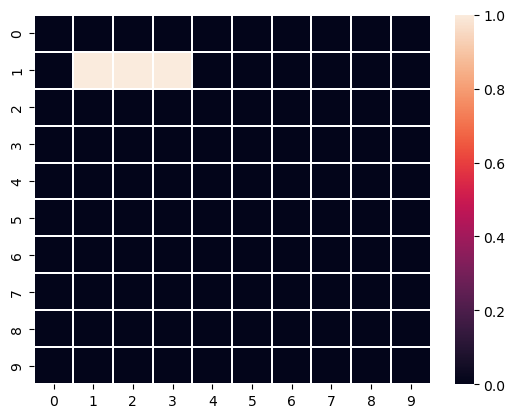

In [49]:
sns.heatmap(foo.get_states(),linewidths=0.1)

<Axes: >

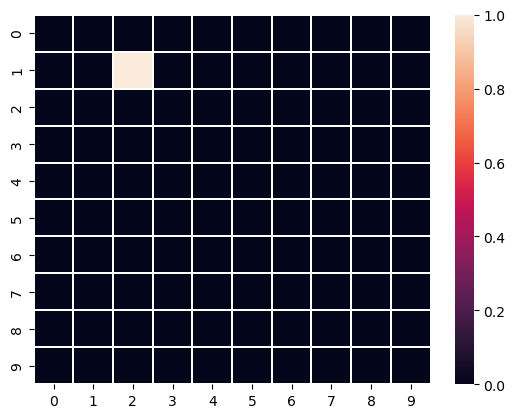

In [54]:
sns.heatmap(np.isin(live_nbrs,survival) & foo.get_states(),linewidths=0.1)

<Axes: >

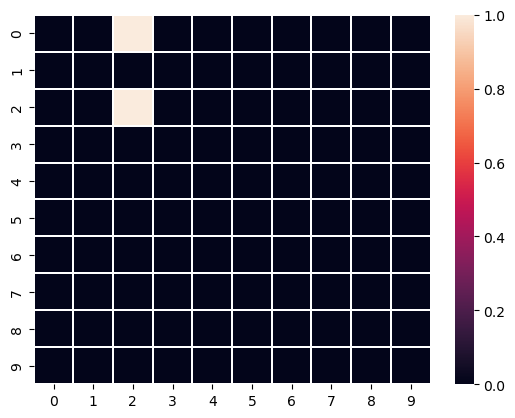

In [57]:
sns.heatmap(np.isin(live_nbrs,birth) & ~foo.get_states(),linewidths=0.1)